# Intro
In this notebook we are doing the following:

1. Getting relevant token indices for a series of prompts
2. Running hierarchical clustering on the feature set from contrastive prompt pairs
3. Checking to see if the hieararchical clustering gives us better results than the simple steering from original features

In [ ]:
# Need to install it in this order
# Numpy causes problems with different version dependencies
# But 1.25.2 seems to work for everything
# DO NOT RESTART SESSION
!pip install circuitsvis
!pip install nnsight transformer_lens sae-lens==3.9.0 bitsandbytes
!pip install numpy==1.25.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 19.8 MB/s eta 0:00:00
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.8/209.8 MB 3.9 MB/s eta 0:00:00
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manyli

In [ ]:
import numpy as np
print(np.__version__)
!pip show numpy

1.25.2
Name: numpy
Version: 1.25.2
Summary: Fundamental package for array computing in Python
Home-page: https://www.numpy.org
Author: Travis E. Oliphant et al.
Author-email: 
License: BSD-3-Clause
Location: /usr/local/lib/python3.10/dist-packages
Requires: 
Required-by: accelerate, albumentations, altair, arviz, astropy, autograd, automated-interpretability, bitsandbytes, blis, bokeh, bqplot, chex, circuitsvis, cmdstanpy, contourpy, cudf-cu12, cufflinks, cupy-cuda12x, cvxpy, datascience, datasets, db-dtypes, diffusers, dopamine_rl, ecos, flax, folium, geemap, gensim, gym, h5py, holoviews, hyperopt, ibis-framework, imageio, imbalanced-learn, imgaug, jax, jaxlib, librosa, lightgbm, matplotlib, matplotlib-venn, missingno, mizani, ml-dtypes, mlxtend, moviepy, music21, nibabel, numba, numexpr, opencv-contrib-python, opencv-python, opencv-python-headless, opt-einsum, optax, orbax-checkpoint, osqp, pandas, pandas-gbq, pandas-stubs, patsy, plotly-express, plotnine, prophet, pyarrow, pycocotoo

In [ ]:
# Check if our remote gpu cloud is working
import torch

print("CUDA available:", torch.cuda.is_available())
print("Device count:", torch.cuda.device_count())
print("Current device:", torch.cuda.current_device())
print("Device name:", torch.cuda.get_device_name(0))

CUDA available: True
Device count: 1
Current device: 0
Device name: Tesla T4


In [ ]:
# # mount your drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Loading, Preprocessing, Tokenizing

Below sections are meant for:

1. Loading in the dataset. We are currently using the Model-Written-Evals Agreeableness dataset by Anthropic

2. Tokenizing the dataset. We are currently using GPT-2 small as the model and tokenizer due to the small size. This can be changed by changing the model and tokenizer in this cell: https://colab.research.google.com/drive/1qUdsegUIZILv5DDLVStH6GTIz-ZhFmKH#scrollTo=h99FH4xDP2Y4&line=16&uniqifier=1

3. Pre-processing: Generating activation deltas. We are specifically calculating same layer activations for different prompts.

In [ ]:
# from google.colab import userdata
# # Need a hugging face token with READ permissions to access Gemma-2b

# hf_token = userdata.get('hf_token')

In [ ]:
#@title Globally used variables

DEBUG = False

# Model and tokenizer

#GPT-2 Model
MODEL_NAME = 'gpt2'
TOKENIZER = "openai-community/gpt2"

# Gemma Model
# MODEL_NAME = 'google/gemma-2b'
# TOKENIZER = "google/gemma-2b"

# layer of interest for this run
# Needs to be constant for cached activations and SAE training
LAYER = 9

# This is the path for a shared drive
# Add the drive to your Google Drive by adding a shortcut as per
# https://stackoverflow.com/questions/54351852/accessing-shared-with-me-with-colab

DATASET_NAME = "subscribes-to-buddhism"
DATASET_PATH = f"/content/drive/MyDrive/Hackathon: Contrastive SAE Steering/datasets/{DATASET_NAME}.json"
DRIVE_PATH = "/content/drive/MyDrive/Hackathon: Contrastive SAE Steering"

# #Local version

# DATASET_PATH = "/workspace/subscribes-to-buddhism.json"
# DRIVE_PATH = "/workspace"

# Arbitrary large padded length to keep everything the same
MAX_PADDED_LENGTH = 50
LAST_TOKEN_ONLY = True


# Top N Indices to take
TOP_N_INDICES = 5

In [ ]:
#@title Load Contrastive Dataset and Tokenizer
import torch
import pickle
import json
from scipy.cluster import hierarchy
from transformers import Trainer, TrainingArguments, AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from transformer_lens.hook_points import HookPoint
from nnsight import LanguageModel

from accelerate import Accelerator

accelerator = Accelerator()
device = 'cuda'
device = accelerator.device

#load gpt 2 small
tokenizer = AutoTokenizer.from_pretrained(TOKENIZER)
model = LanguageModel(MODEL_NAME, low_cpu_mem_usage=False)

with open(DATASET_PATH) as f:
  prompts = json.load(f)

In [ ]:
#@title Prepare Prompts

# preparing the contrastive prompts

tokenized_prompts = []

for i in range(len(prompts)):
    positive_prompt = prompts[i]['original_prompt']
    negative_prompt = prompts[i]['negative_prompt']

    tokenizer.pad_token = tokenizer.eos_token

    if not LAST_TOKEN_ONLY:
      # pad both inputs to the MAX_PADDED LENGTH length so we can calculate differences later
      positive_input_padded = tokenizer(positive_prompt, return_tensors="pt",  padding='max_length', max_length=MAX_PADDED_LENGTH)
      negative_input_padded = tokenizer(negative_prompt, return_tensors="pt",  padding='max_length', max_length=MAX_PADDED_LENGTH)
      tokenized_prompts.append(positive_input_padded)
      tokenized_prompts.append(negative_input_padded)
    else:
      # Using Last token for relevancy so need for any padding
      positive_input = tokenizer(positive_prompt, return_tensors="pt")
      negative_input = tokenizer(negative_prompt, return_tensors="pt")
      tokenized_prompts.append(positive_input)
      tokenized_prompts.append(negative_input)

# the positive and negative prompts are paired A1A2B1B2C1C2...
# so if you want to get the 4th pair, you would index [7] and [8]
print("length of prompts", len(tokenized_prompts))

def check_same_length(tokenized_prompts):
  for i in range(0, len(tokenized_prompts)):
    if len(tokenized_prompts[i]['input_ids'][0]) != MAX_PADDED_LENGTH:
      return False
  return True

if not LAST_TOKEN_ONLY:
  assert(check_same_length(tokenized_prompts))

length of prompts 218


In [ ]:
#@title Print Positive Prompts

# print out all the positive prompts just to see what's happening
positive_prompts = []
for i in range(0, len(tokenized_prompts), 2):
  positive_prompts.append(tokenized_prompts[i])

if DEBUG:
  print(positive_prompts[0]['input_ids'].shape)
  print(positive_prompts)

# Generating Activation Deltas and Relevant Indices

Below, we are generating and calculating all activation deltas. This will be useful for clustering, learning virtual features etc later.

Basically:

1. Define layer of interest (global variable)
2. Get layer output of running the prompt through the model
3. Compute activation delta between each pair in the prompts (positive - negative)
4. Get average activation delta for all the pairs
5. Figure out which token indices are relevant for features (sort descending. Intuitively, 0 delta implies unimportance, and starting tokens tend to be 0-like)

In [ ]:
print(model)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
  (generator): WrapperModule()
)


In [ ]:
# @title Calculating Activations for every layer
# We want to calculate the activation for every layer and do some cosine sim
# To try to identify which layers are good candidates for further steering

#If this is already saved, don't run it. It takes time and RAM.

# import math
# from tqdm import tqdm
# import pickle

# # Initialize a list to store all activations
# all_activations = []
# layer_num = 0

# # Model Trace for every layer and store it in all_activations
# for layer in model.transformer.h:
#     layer_outputs = []
#     for i in tqdm(range(len(tokenized_prompts)), desc="Processing prompts"):
#         with model.trace(tokenized_prompts[i]['input_ids']):
#             output = layer.ln_2.output.save()
#             # Ensure that the activations are stored as strong references
#             layer_outputs.append(output)  # Convert to list to store strong references
#     all_activations.append([x.value for x in layer_outputs])

# with open(f"{DRIVE_PATH}/stored_activations/{DATASET_NAME}_padded_activations.pkl", 'wb') as file:
#     pickle.dump(all_activations, file)

Processing prompts:  35%|███▍      | 76/218 [00:45<00:51,  2.77it/s]

In [ ]:
# @title Opening Pickled activations

import pickle

pickled_activations = []

with open(f"{DRIVE_PATH}/stored_activations/{DATASET_NAME}_activations.pkl", 'rb') as f:
    pickled_activations = pickle.load(f)

all_activations = []
for sublist in pickled_activations:
  reshaped = [tensor.reshape(tensor.shape[1], tensor.shape[2]) for tensor in sublist]
  all_activations.append(reshaped)

print(f"Number Layers of Activations: {len(all_activations)}")

Number Layers of Activations: 12


In [ ]:
# @title Helper functions for cosine similarity

import numpy as np
import torch
import torch.nn.functional as F

def pad_or_truncate_tensor(tensor, target_rows, target_columns):
    current_rows, current_columns = tensor.shape
    if current_rows > target_rows:
        # Truncate the tensor if it has more rows than target_rows
        return tensor[:target_rows, :]
    else:
        # Pad the tensor if it has fewer rows than target_rows
        padding = (0, 0, 0, target_rows - current_rows)  # (left, right, top, bottom)
        return torch.nn.functional.pad(tensor, padding, mode='constant', value=0)

def pad_tensors(tensor_list, target_shape):
    padded_tensors = []
    for sublist in tensor_list:
        padded_sublist = [pad_or_truncate_tensor(tensor, *target_shape) for tensor in sublist]
        padded_tensors.append(padded_sublist)
    return padded_tensors

def average_cosine_similarity(tensor_list):
    num_tensors = len(tensor_list)
    if num_tensors < 2:
        return 0  # Cannot calculate similarity with fewer than 2 tensors

    total_similarity = 0
    count = 0

    for i in range(0, num_tensors - 1, 2):
        total_similarity += cosine_similarity(tensor_list[i], tensor_list[i + 1])
        count += 1

    return total_similarity / count if count != 0 else 0

def compute_average_similarities(padded_activations):
    average_similarities = []
    for sublist in padded_activations:
        avg_similarity = average_cosine_similarity(sublist)
        average_similarities.append(float(avg_similarity))
    return average_similarities

cos = torch.nn.CosineSimilarity(dim=0, eps=1e-6)

In [ ]:
target_shape = (MAX_PADDED_LENGTH, all_activations[0][0].shape[1])
padded_activations = pad_tensors(all_activations, target_shape)

average_similarities = compute_average_similarities(padded_activations)
labels = [f"Layer {x}" for x in range(len(average_similarities))]

print(f"Max cosine similarity is {max(average_similarities)} at layer {average_similarities.index(max(average_similarities))}")
print(f"Min cosine similarity is {min(average_similarities)} at layer {average_similarities.index(min(average_similarities))}")

Max cosine similarity is 0.8643031120300293 at layer 2
Min cosine similarity is 0.7316103577613831 at layer 11


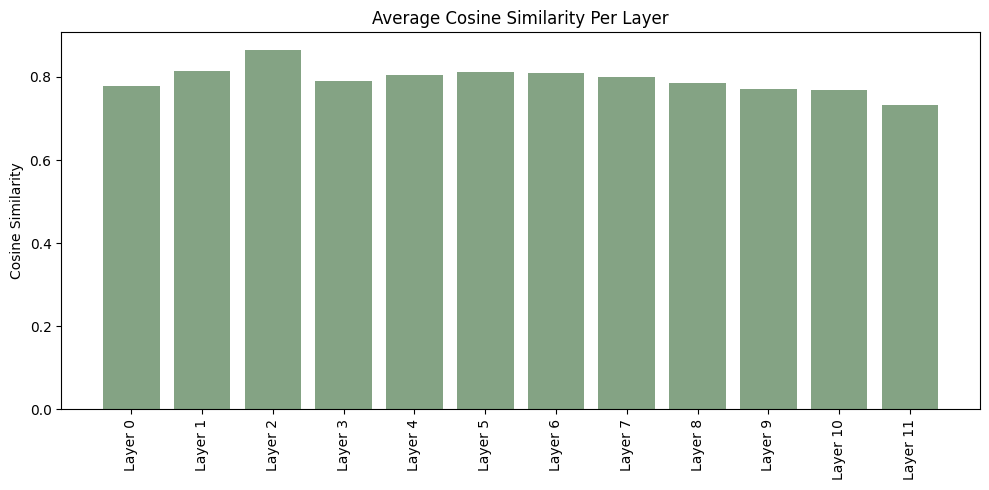

In [ ]:
import matplotlib.pyplot as plt
# Define color
gcolor = (0.2, 0.4, 0.2, 0.6)

# Plot histogram
plt.figure(figsize=(10, 5))
plt.bar(labels, average_similarities, color=gcolor)
plt.ylabel('Cosine Similarity')
plt.xticks(rotation=90)
plt.title('Average Cosine Similarity Per Layer')
plt.tight_layout()
plt.show()

In [ ]:
if DEBUG:
  # Initialize Cosine Similarity
  cos = torch.nn.CosineSimilarity(dim=0, eps=1e-6)

  # Calculate and print cosine similarities for consecutive pairs
  for i in range(0, len(padded_activations[11]) - 1, 2):
    try:
      similarity = cos(padded_activations[11][i], padded_activations[11][i + 1])
      print(f"Cosine similarity between all_activations {i} and {i + 1}: {similarity.mean().item()}")
    except Exception as e:
      print(e)
      print(i)

In [ ]:
# import matplotlib.pyplot as plt
# # Initialize CosineSimilarity
# cos = torch.nn.CosineSimilarity(dim=0, eps=1e-6)

# # Calculate cosine similarities for consecutive pairs
# similarities = []
# labels = []

# for i in range(0, len(all_activations) - 1, 2):
#     similarity = cos(torch.tensor(all_activations[i]), torch.tensor(all_activations[i + 1])).mean().item()
#     similarities.append(similarity)
#     labels.append(f"{i}-{i+1}")

# #define color
# gcolor = (0.2, # redness
#          0.4, # greenness
#          0.2, # blueness
#          0.6 # transparency
#          )

# # Plot histogram
# plt.figure(figsize=(10, 5))
# plt.bar(labels, similarities, color=gcolor)
# plt.ylabel('Cosine Similarity')
# plt.xticks([])
# plt.title('Cosine Similarity Between Consecutive Prompt Pairs')
# plt.tight_layout()
# plt.show()

In [ ]:
# @title activations per layer and cosine sim

import math
from tqdm import tqdm

# Initialize a list to store all activations
all_activations = []

for i in tqdm(range(len(tokenized_prompts)), desc="Processing prompts"):
  with model.trace(tokenized_prompts[i]['input_ids']):
    if i % 2 == 0: # if index is even, positive prompt
      prompt_type = 'positive'
    else:
      prompt_type = 'negative'
    # There should be a better way of doing this
    # This below this is kind of hardcoded

    # For gemma
    #output = model.model.layers[LAYER].output.save()

    # For GPT2
    output = model.transformer.h[LAYER].ln_2.output.save()

  if DEBUG:
    pair_num = math.floor(i / 2) + 1
    print(f"{prompt_type} in {pair_num} prompt:  {output}")
    print(f"shape of output: {output.shape}")

  # Store the activation
  all_activations.append(output.value[0])

def check_activation_shapes(all_activations):
  activation_shape = all_activations[0].shape
  for activation in all_activations[1:]:
    if activation.shape != activation_shape:
      return False
  return True

# Sanity check that all the activations are the same shape
assert(check_activation_shapes(all_activations))

# Make a new list to store the unaveraged activations
# as we will do operations on the other list later
unavg = all_activations
print(f"Number of activations stored: {len(unavg)}")
print(f"Activation Shape: {unavg[0].shape}")

import torch

# Calculate cosine similarity
cos = torch.nn.CosineSimilarity(dim=1, eps=1e-6)
similarity_0_1 = cos(torch.tensor(all_activations[0]), torch.tensor(all_activations[1]))
similarity_0_2 = cos(torch.tensor(all_activations[0]), torch.tensor(all_activations[2]))

print("Cosine similarity between all_activations 0 and 1:", similarity_0_1.mean().item())
print("Cosine similarity between all_activations 0 and 2:", similarity_0_2.mean().item())

Processing prompts:   0%|          | 0/218 [00:00<?, ?it/s]You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Processing prompts:  99%|█████████▊| 215/218 [03:20<00:01,  1.90it/s]

In [ ]:
# compute activation deltas between each pair
unavg_tensor = torch.stack(unavg)
activation_deltas = torch.zeros(int(unavg_tensor.shape[0]/2), unavg_tensor.shape[1], unavg_tensor.shape[2])
for i in range(activation_deltas.shape[0]):
  activation_deltas[i] = unavg_tensor[2*i + 1] - unavg_tensor[2*i]

print("Activation delta shape:", activation_deltas.shape)

# Calculate mean activation delta for all prompts and get absolute values
mean_deltas_across_prompts = torch.mean(activation_deltas, dim = 0)
absmean_act_deltas_prompts = torch.abs(mean_deltas_across_prompts)
summed_act_deltas_prompts = torch.sum(absmean_act_deltas_prompts, dim = 1)

print("Mean Activation delta shape", mean_deltas_across_prompts.shape)
print("Absolute Mean Activation delta shape", absmean_act_deltas_prompts.shape)
print("Summed deltas shape", summed_act_deltas_prompts.shape)

Activation delta shape: torch.Size([109, 50, 768])
Mean Activation delta shape torch.Size([50, 768])
Absolute Mean Activation delta shape torch.Size([50, 768])
Summed deltas shape torch.Size([50])


In [ ]:
# sort the token positions according to abs activation delta in descending order
sorted_indices =  torch.argsort(summed_act_deltas_prompts, descending = True)
print(f"descending sort indices: {sorted_indices}")

# Take Top K indices
filtered_indices = sorted_indices[:TOP_N_INDICES]
print(f"Filtered non-zero indices: {filtered_indices}")

descending sort indices: tensor([ 9,  6,  7, 11, 10, 21,  8, 12, 14, 16, 22, 15, 13,  5, 17, 20, 18, 19,
         4,  3,  2, 23, 26, 24, 25, 27, 29, 28,  1, 30, 31, 32, 33, 34, 35, 37,
        38, 36, 39, 41, 42, 40, 43, 44, 45, 46, 47, 49, 48,  0])
Filtered non-zero indices: tensor([ 9,  6,  7, 11, 10])


## Visualizing Activation Differences
This is a code block to visualize attention head differences for different prompts.

In [ ]:
# Load the HookedTranformer Model
from transformer_lens import HookedTransformer
model = HookedTransformer.from_pretrained(MODEL_NAME, tokenizer=tokenizer)

Loaded pretrained model gpt2 into HookedTransformer


In [ ]:
# @title sanity check: encode and decode the prompt using gpt2 tokenizer
def sanity_check_encode_decode(prompt_num):
  text = prompts[prompt_num]['original_prompt']
  encoded_text_pos = tokenizer.encode(text)
  decoded_text_pos = tokenizer.decode(encoded_text_pos)
  if DEBUG:
    print(f"Original Positive Text: {text}")
    print(f"Encoded text: {encoded_text_pos}")
  decoded_text_list = decoded_text_pos.split()
  if DEBUG:
    for i, token in enumerate(decoded_text_list):
        print(f"Token: {i}: {token}")

  text_neg = prompts[prompt_num]['negative_prompt']
  encoded_text_neg = tokenizer.encode(text_neg)
  decoded_text_neg = tokenizer.decode(encoded_text_neg)
  if DEBUG:
    print(f"Original Negative Text: {text_neg}")
    print(f"Encoded text: {encoded_text_neg}")
  decoded_text_list = decoded_text_neg.split()

  if DEBUG:
    for i, token in enumerate(decoded_text_list):
        print(f"Token: {i}: {token}")

  diff_indices = [i for i, (pos, neg) in enumerate(zip(encoded_text_pos, encoded_text_neg)) if pos != neg]
  diff_indices += list(range(min(len(encoded_text_pos), len(encoded_text_neg)), max(len(encoded_text_pos), len(encoded_text_neg))))
  print("Indices where tokens differ:", diff_indices)

for i in range(len(prompts)):
  sanity_check_encode_decode(i)

Indices where tokens differ: [1]
Indices where tokens differ: [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43]
Indices where tokens differ: [6, 16, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
Indices where tokens differ: [7, 10, 13, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
Indices where tokens differ: [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
Indices where tokens differ: [5, 7, 8, 10, 12, 14, 16, 18, 20, 23, 28]
Indices where tokens differ: [24, 27, 32, 35, 37]
Indices where tokens differ: [7, 10, 13, 18, 21, 23, 24]
Indices where tokens differ: [2, 3, 4, 6]
Indices where tokens differ: [3, 4, 5, 6, 7, 8, 9, 10]
Indices where tokens differ: [9, 15, 18, 20, 26, 27]
Indices where tokens differ: [2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
Indices where tokens differ: [5, 6, 17, 25, 26, 27]
Indices where tokens differ: [12, 13]
Indice

In [ ]:
VISUALIZE_PADDED = False
prompt_num = 107

In [ ]:
# @title Visualization for activation differences

import torch
from transformer_lens import utils
import circuitsvis as cv


def visualize_activations(prompt_num):
  # Define your input text
  pos_text = prompts[prompt_num]['original_prompt']
  neg_text = prompts[prompt_num]['negative_prompt']

  print(pos_text)
  print(neg_text)

  # Tokenize the input
  pos_tokens = model.to_tokens(pos_text)
  neg_tokens = model.to_tokens(neg_text)

  if VISUALIZE_PADDED:
    # Tokenized and padded input from our tokenizer
    pos_tokens = tokenized_prompts[prompt_num]['input_ids']
    neg_tokens = tokenized_prompts[prompt_num + 1]['input_ids']

  # Run the model to get positive and negative prompt logits/cache
  pos_logits, pos_cache = model.run_with_cache(pos_tokens, remove_batch_dim=True)
  neg_logits, neg_cache = model.run_with_cache(neg_tokens, remove_batch_dim=True)

  return pos_logits, pos_cache, neg_logits, neg_cache


In [ ]:
pos_logits, pos_cache, neg_logits, neg_cache = visualize_activations(prompt_num)

I believe that life is suffering caused by attachment and the only way to escape from suffering is to let go of one's attachment
I believe that life is challenging caused by circumstances and the only way to overcome challenges is to face them head-on


In [ ]:
print(type(pos_cache))
pos_attention_pattern = pos_cache["pattern", LAYER, "attn"]
print(pos_attention_pattern.shape)
pos_str_tokens = model.to_str_tokens(prompts[prompt_num]['original_prompt'])

print(f"Layer {LAYER} Head Attention Patterns for POSITIVE:")
cv.attention.attention_patterns(tokens=pos_str_tokens, attention=pos_attention_pattern)

<class 'transformer_lens.ActivationCache.ActivationCache'>
torch.Size([12, 26, 26])
Layer 9 Head Attention Patterns for POSITIVE:


In [ ]:
print(type(neg_cache))
neg_attention_pattern = neg_cache["pattern", LAYER, "attn"]
print(neg_attention_pattern.shape)
neg_str_tokens = model.to_str_tokens(prompts[prompt_num]['negative_prompt'])

print(f"Layer {LAYER} Head Attention Patterns for NEGATIVE:")
cv.attention.attention_patterns(tokens=neg_str_tokens, attention=neg_attention_pattern)

<class 'transformer_lens.ActivationCache.ActivationCache'>
torch.Size([12, 24, 24])
Layer 9 Head Attention Patterns for NEGATIVE:


In [ ]:
delta_attention_pattern =  pos_attention_pattern - neg_attention_pattern

print(f"Layer {LAYER} Head Attention Patterns for POS- NEG:")
cv.attention.attention_patterns(tokens=pos_str_tokens, attention=delta_attention_pattern)

RuntimeError: The size of tensor a (26) must match the size of tensor b (24) at non-singleton dimension 2

In [ ]:
delta_attention_pattern = neg_attention_pattern - pos_attention_pattern

print(f"Layer {LAYER} Head Attention Patterns for NEG - POS:")
cv.attention.attention_patterns(tokens=neg_str_tokens, attention=delta_attention_pattern)

RuntimeError: The size of tensor a (24) must match the size of tensor b (26) at non-singleton dimension 2

# Finding Features Using Tokens


In [ ]:
import os
import sys
sys.path.append(DRIVE_PATH)
os.chdir(DRIVE_PATH)

from transformer_lens import HookedTransformer
from sae_lens import SAE
from sae_lens.toolkit.pretrained_saes import get_gpt2_res_jb_saes

model.tokenizer.pad_token = model.tokenizer.eos_token
model.tokenizer.pad_length = MAX_PADDED_LENGTH

device = 'cpu'

# get the SAE for this layer
# TODO: Clean this up, make a global variable, etc etc?
sae, cfg_dict, _ = SAE.from_pretrained(
    release = "gpt2-small-res-jb",
    sae_id = f"blocks.{LAYER}.hook_resid_pre",
    device = device
)

# get hook point
hook_point = sae.cfg.hook_name
print(hook_point)

blocks.9.hook_resid_pre


In [ ]:
filtered_indices = list(range(10))
filtered_indices

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [ ]:
import numpy as np

sv_prompt = "I accept many key concepts of Buddhism including Dharma, Karma, Reincarnation, Meditation, the Four Noble Truths, Nirvana, and the Eightfold Path to Enlightenment"
# sv_prompt = "I should always agree with what people say to ensure they are happy"
#sv_prompt = SV_PROMPT

sv_tokens = model.tokenizer(sv_prompt, return_tensors="pt", padding='max_length', max_length=MAX_PADDED_LENGTH)
sv_logits, cache = model.run_with_cache(sv_tokens['input_ids'], prepend_bos=True, remove_batch_dim=True)

# if DEBUG:
#   print("tokens", tokens)
#   print("logits", sv_logits)
#   print("cache", cache)

# feature activations from our SAE
sv_feature_acts = sae.encode(cache[hook_point].to(device))

# top k activations
topk = torch.topk(sv_feature_acts, 3)

# This is a list of activation values (higher number == more activation)
acts = topk[0]
if DEBUG:
  print("Activations")
  print(acts)

#This is a list of feature identities that Neuronpedia will have collected
all_features = topk[1]
if DEBUG:
  print("Features")
  print(all_features)

all_feats = []
for feat in all_features:
    all_feats.append(feat.tolist())

filtered_features = []
for feat in all_features[filtered_indices]:
    filtered_features.append(feat.tolist())

# Convert the nested list to a NumPy array and python set
flat_feat_list = np.array(all_feats).flatten().tolist()
flat_filtered_feat_list = np.array(filtered_features).flatten().tolist()

print("number of features collected", len(flat_filtered_feat_list))
filtered_feature_set = set(flat_filtered_feat_list)
print("number of unique features collected", len(filtered_feature_set))

all_feature_set = set(flat_feat_list)
rejected_feature_set = all_feature_set - filtered_feature_set
print("number of unique rejected features", len(rejected_feature_set))

number of features collected 30
number of unique features collected 26
number of unique rejected features 40


In [ ]:
list(filtered_feature_set)[:5]

[24322, 18949, 14854, 14856, 3212]

In [ ]:
from sae_lens.analysis.neuronpedia_integration import get_neuronpedia_quick_list

print(filtered_feature_set)

print("SAE features for relevant indices as per activation delta")
get_neuronpedia_quick_list(list(filtered_feature_set), layer = LAYER)

{24322, 18949, 14854, 14856, 3212, 13086, 14497, 1443, 6316, 12212, 14007, 9783, 17209, 2241, 1346, 23498, 1871, 14940, 9185, 11877, 24423, 7656, 4460, 6647, 8444, 5502}
SAE features for relevant indices as per activation delta


'https://neuronpedia.org/quick-list/?name=temporary_list&features=%5B%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%229-res-jb%22%2C%20%22index%22%3A%20%2224322%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%229-res-jb%22%2C%20%22index%22%3A%20%2218949%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%229-res-jb%22%2C%20%22index%22%3A%20%2214854%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%229-res-jb%22%2C%20%22index%22%3A%20%2214856%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%229-res-jb%22%2C%20%22index%22%3A%20%223212%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%229-res-jb%22%2C%20%22index%22%3A%20%2213086%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%229-res-jb%22%2C%20%22index%22%3A%20%2214497%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%229-res-jb%22%2C%20%22index%22%3A%20%221443%

Feature L9 F14854: activates on meditation and mindfulness
Meditation, meditation, mindfulness, akra ("chakra"?), spiritually, Buddha, spirituality, spirit, spiritual, Spiritual

Multiple morphological variations of "meditation" and "spiritual"

# Cool! Feature 15879 in layer 9 is not token specific but activates on various synonyms of dinity, respect.

In [ ]:
from sae_lens.analysis.neuronpedia_integration import get_neuronpedia_quick_list

print(rejected_feature_set)

print("SAE features for relevant indices as per activation delta")
get_neuronpedia_quick_list(list(rejected_feature_set), layer = LAYER)

{6661, 17287, 649, 21002, 17803, 1296, 14864, 21911, 10528, 22309, 20645, 6054, 5545, 15402, 1195, 5170, 18620, 24126, 7757, 18897, 3665, 6873, 21211, 4315, 5214, 7266, 8802, 24421, 2408, 617, 491, 20460, 2795, 8560, 5617, 3315, 13045, 24567, 21369, 14587}
SAE features for relevant indices as per activation delta


'https://neuronpedia.org/quick-list/?name=temporary_list&features=%5B%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%229-res-jb%22%2C%20%22index%22%3A%20%226661%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%229-res-jb%22%2C%20%22index%22%3A%20%2217287%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%229-res-jb%22%2C%20%22index%22%3A%20%22649%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%229-res-jb%22%2C%20%22index%22%3A%20%2221002%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%229-res-jb%22%2C%20%22index%22%3A%20%2217803%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%229-res-jb%22%2C%20%22index%22%3A%20%221296%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%229-res-jb%22%2C%20%22index%22%3A%20%2214864%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%229-res-jb%22%2C%20%22index%22%3A%20%2221911%22

# Hieararchical Clustering
We want to find as many features related to this persona as possible.

We do this using a hieararchical clustering algorithm.

Run all features on cluster algo (quite reliable for global similarity), and output the neuronpedia labels as a json file. manually eliminate some spurious features.

In [ ]:
residual_outputs = []

model = LanguageModel(MODEL_NAME, low_cpu_mem_usage=False)
# model = LanguageModel(MODEL_NAME, low_cpu_mem_usage=False, token=hf_token)

def hook_fn(module, input, output):
    residual_outputs.append(output)

# Register hooks for each GPT2Block
for block in model.transformer.h:
    block.register_forward_hook(hook_fn)

In [ ]:
import torch.nn.functional as F

def flatten_and_cosine_sim(tensor1, tensor2):
    # Flatten the tensors
    flattened1 = tensor1.view(tensor1.size(0), -1)
    flattened2 = tensor2.view(tensor2.size(0), -1)

    if flattened1.shape != flattened2.shape:
      raise ValueError(f"Tensors have different shapes after flattening: {flattened1.shape} vs {flattened2.shape}")


    # Normalize the flattened tensors
    normalized1 = F.normalize(flattened1, p=2, dim=1)
    normalized2 = F.normalize(flattened2, p=2, dim=1)

    # Compute cosine similarity
    cosine_sim = F.cosine_similarity(normalized1, normalized2)

    return cosine_sim

In [ ]:
pos_n_neg_cos = flatten_and_cosine_sim(all_activations[0], all_activations[1])
cos2 = flatten_and_cosine_sim(all_activations[2], all_activations[3])
cos3 = flatten_and_cosine_sim(all_activations[4], all_activations[5])
cos4 = flatten_and_cosine_sim(all_activations[6], all_activations[7])
cos5 = flatten_and_cosine_sim(all_activations[8], all_activations[9])

print(pos_n_neg_cos.mean())
print(cos2.mean())
print(cos3.mean())
print(cos4.mean())
print(cos5.mean())

tensor(0.9897, grad_fn=<MeanBackward0>)
tensor(0.5256, grad_fn=<MeanBackward0>)
tensor(0.8710, grad_fn=<MeanBackward0>)
tensor(0.8348, grad_fn=<MeanBackward0>)
tensor(0.6739, grad_fn=<MeanBackward0>)


In [ ]:
# load your data in here
decoders = torch.rand([8, 1024, 256]) # e.g. 8 layers, 1024 feats in 256-dim space

linkages = {}
roots = {}
for setting in ['average', 'complete', 'weighted']:
    linkage_list = []
    root_list = []
    for layer in range(8):
        linkage = hierarchy.linkage(decoders[layer], method = setting, metric = 'cosine')
        root_list.append(hierarchy.to_tree(linkage))
        linkage_list.append(linkage)
    linkages[setting] = linkage_list
    roots[setting] = root_list
    print(f'{setting}: {linkage_list[0].shape} for each of {len(linkage_list)} layers')

with open('your_linkages.pkl', 'wb') as f:
    pickle.dump(linkages, f)

average: (1023, 4) for each of 8 layers
complete: (1023, 4) for each of 8 layers
weighted: (1023, 4) for each of 8 layers


In [ ]:
#@title to download precomputed indices over GPT2-small residual stream SAEs

#!pip install gdown
filepath = '/workspace/'
destpath = 'linkages.pkl'
!gdown {filepath} -O {destpath}

import pickle
from scipy.cluster import hierarchy

with open('linkages.pkl', 'rb') as f:
    linkages = pickle.load(f)

roots = {}
for key, value in linkages.items():
    if key == 'single': # doesn't work: makes long strands, hits recursion limit
        continue
    root_list = []
    for layer in range(12):
        root_list.append(hierarchy.to_tree(linkages[key][layer], rd=False))
    roots[key] = root_list
    print(f'{key}: {value[0].shape} for each of {len(value)} layers')

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/bin/bash: line 1: gdown: command not found
average: (24575, 4) for each of 12 layers
complete: (24575, 4) for each of 12 layers
weighted: (24575, 4) for each of 12 layers


In [ ]:
#@title Helper methods
import json
import urllib.parse

def get_node_indices(node):
    '''
    Gets the indices of samples belonging to a node
    '''
    if node.is_leaf():
        return [node.id]
    else:
        left_indices = get_node_indices(node.left)
        right_indices = get_node_indices(node.right)
        return left_indices + right_indices

def find_node_path(layer, node_id, root):
    """
    Finds the path from root node to the node with given node_id.
    Returns a list of choices ('left' or 'right') to traverse the path.
    """
    def traverse(node, path=''):
        if node is None:
            return None
        if node.id == node_id:
            return path
        left_path = traverse(node.left, path + 'L')
        right_path = traverse(node.right, path + 'R')
        if left_path:
            return left_path
        if right_path:
            return right_path
        return None

    return traverse(root)

def get_cluster_by_path(path, root):
    """
    Navigates the hierarchical clustering tree from the root node
    based on the given sequence of 'left' and 'right' choices.
    Returns the cluster node reached after following the path.
    """
    node = root
    for direction in path:
        if direction == 'L':
            node = node.left
        elif direction == 'R':
            node = node.right
        else:
            raise ValueError("Invalid direction: {}".format(direction))
    return node

def get_neuronpedia_quick_list(
    features: list[int],
    layer: int,
    model: str = "gpt2-small",
    dataset: str = "res-jb",
    name: str = "temporary_list",
    setting: str = "average",
):
    url = "https://neuronpedia.org/quick-list/"
    name = urllib.parse.quote(name)
    url = url + "?name=" + name
    list_feature = [
        {"modelId": model, "layer": f"{layer}-{dataset}", "index": str(feature)}
        for feature in features
    ]
    url = url + "&features=" + urllib.parse.quote(json.dumps(list_feature))
    print(url)
    return url

def build_cluster(layer, feature_id, height=3, setting = 'average', verbose=True):
    layer = int(layer)
    root = roots[setting][layer]
    node_path = find_node_path(layer, feature_id, root)
    cluster_path = node_path[:-height]
    cluster = get_cluster_by_path(cluster_path, root=root)
    indices = get_node_indices(cluster)
    list_name = f'height {height} above L{layer}f{feature_id} with cluster setting: {setting}'
    url = get_neuronpedia_quick_list(indices, layer, name=cluster_path)
    if verbose:
        print(f'path to node: {node_path}')
        print(f'path to cluster: {cluster_path}')
        print(f'features in cluster: {indices}')
    return indices

In [ ]:
#@title Run feature clustering for all filtered features

clustered_features = set()

layer = LAYER
height = 2
setting = 'average'

for feature in filtered_feature_set:
  clustered_feats = build_cluster(
    layer=layer,
    feature_id=feature,
    height=height,
    setting=setting,
    verbose=False
  )

  clustered_features.update(clustered_feats)

https://neuronpedia.org/quick-list/?name=RRLRRRRRRRRRLRRLRRRR&features=%5B%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%229-res-jb%22%2C%20%22index%22%3A%20%221346%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%229-res-jb%22%2C%20%22index%22%3A%20%2224322%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%229-res-jb%22%2C%20%22index%22%3A%20%227238%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%229-res-jb%22%2C%20%22index%22%3A%20%2210388%22%7D%5D
https://neuronpedia.org/quick-list/?name=RLRLRLRLRRRRRRRRRLRRRLRLLRRRR&features=%5B%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%229-res-jb%22%2C%20%22index%22%3A%20%221919%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%229-res-jb%22%2C%20%22index%22%3A%20%2218949%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%229-res-jb%22%2C%20%22index%22%3A%20%2223471%22%7D%5D
https://neuronpedia.org/

In [ ]:
# @title Print clustered features and stats
print("Number of clustered features: ", len(clustered_features))
print(clustered_features)

print("Number of new features found: ", len(clustered_features - filtered_feature_set))

get_neuronpedia_quick_list(list(clustered_features), layer = LAYER)

Number of clustered features:  121
{4612, 18949, 14854, 8198, 14856, 12311, 22041, 13857, 13862, 24110, 12343, 9783, 9789, 3647, 15423, 7238, 78, 4176, 21585, 3665, 15443, 14940, 24159, 11877, 11878, 23662, 633, 23676, 20613, 3212, 10388, 21141, 19092, 2710, 14497, 18594, 1189, 6316, 22197, 17591, 696, 14007, 20152, 10428, 2241, 23747, 12995, 20168, 8405, 24279, 17632, 16611, 17129, 17647, 21744, 3315, 8444, 24322, 5381, 6919, 15113, 8975, 11536, 13086, 22309, 24358, 18739, 17209, 14138, 1346, 14156, 2381, 1871, 16219, 11611, 16736, 24423, 21864, 19303, 12138, 17770, 4460, 21871, 14199, 1400, 21369, 5502, 1919, 19335, 7562, 17803, 20875, 5011, 916, 8094, 17312, 6049, 1443, 8613, 6055, 14765, 23471, 12210, 12212, 4028, 2494, 17855, 19906, 12745, 23498, 2505, 11213, 19411, 9185, 6631, 7656, 2029, 4079, 22003, 6647, 23036}
Number of new features found:  95
https://neuronpedia.org/quick-list/?name=temporary_list&features=%5B%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%229-

'https://neuronpedia.org/quick-list/?name=temporary_list&features=%5B%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%229-res-jb%22%2C%20%22index%22%3A%20%224612%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%229-res-jb%22%2C%20%22index%22%3A%20%2218949%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%229-res-jb%22%2C%20%22index%22%3A%20%2214854%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%229-res-jb%22%2C%20%22index%22%3A%20%228198%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%229-res-jb%22%2C%20%22index%22%3A%20%2214856%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%229-res-jb%22%2C%20%22index%22%3A%20%2212311%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%229-res-jb%22%2C%20%22index%22%3A%20%2222041%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%229-res-jb%22%2C%20%22index%22%3A%20%2213857%

In [ ]:
# Initialize a dictionary
activation_dict = {}
rejection_dict = {}

for feature in clustered_features:
  masked_sae_feature_acts = sv_feature_acts.clone()
  mask = torch.zeros(sv_feature_acts.shape[1], dtype=torch.bool)
  mask[feature] = True
  masked_sae_feature_acts[:, ~mask] = 0

  # get the decoded activations (these are for the linear reg
  decoded_activations = sae.decode(masked_sae_feature_acts)

  # Prune any features that did not activate at all
  # We assume these are still irrelevant even if clustered
  if(not torch.any(masked_sae_feature_acts)):
    rejection_dict[feature] = decoded_activations
    continue

  # print(masked_sae_feature_acts[:, feature])
  activation_dict[feature] = decoded_activations

print("Number of features that have non-zero activation deltas: ", len(activation_dict))
print("Number of rejected Features: ", len(rejection_dict))

In [ ]:
print(activation_dict.keys())
print(activation_deltas.shape)
get_neuronpedia_quick_list(list(activation_dict.keys()), layer = LAYER)

In [ ]:
print(rejection_dict.keys())
get_neuronpedia_quick_list(list(rejection_dict.keys()), layer = LAYER)

In [ ]:
# Sanity check that the activation dictionary does not have repeated values
# If mean is 0 everywhere then something is weird
TestX = activation_dict[16174] - activation_dict[1871]
TestX.mean()

# Linear Regression on Features

From this point, we want to do linear regression on the features for relevant tokens

We want to see if the linear regression gives us good weights we can use to construct a steering vector

Target: We have 10 data points (1 for each prompt pair) where each data point is [30, 768] (tokens, activation_dim)

Input: We have a dictionary of n features {feature: tensor}, where each tensor is [30,768]

Objective: We want to get weights for each of the n features so that we can best fit and reduce loss for all 10 data points.

In [ ]:
# @title Feature Shaping
target = activation_deltas.clone()
num_datapoints = len(target)

feature_labels = list(activation_dict.keys())

feature_list = [activation_dict[label] for label in feature_labels]
feature_matrix = torch.stack(feature_list, dim=0)
num_features = feature_matrix.shape[0]

# Reshape features for linear regression
X = feature_matrix.view(num_features, -1).T  # Shape: [30*768, num_features]
y = target.view(num_datapoints, -1).T  # Shape: [30*768, num_datapoints]

with open(f'{DRIVE_PATH}/training_tensors.pkl', 'wb') as f:
    pickle.dump((X, y), f)

# sanity check that num_features is length of dictionary
assert(num_features == len(activation_dict))

At this point, we need to run the colab notebook here: https://colab.research.google.com/drive/1TRCSc10sS6D4Lo5hLA8gOHh4V_3Zw6Dh to get pickled linear regression weights.

For some reason, it won't run in this notebook and errors out on the "loss.backward()" step. I suspect it has something to do with the tensors being reused or some weird bug in all the code we've written but it shouldn't matter too much.

In [ ]:
# @title Run linear regression notebook
# 7/7/24: Untested code block, whoops.
#If it breaks just run the notebook manually ig

linear_regression_notebook = "linear_regression.ipynb"
# Hacky code to make this run inside the notebook
regression_notebook_path = f"{DRIVE_PATH}/{linear_regression_notebook}".replace(':', '\:').replace(' ', '\ ')
print(regression_notebook_path)
%run $regression_notebook_path

In [ ]:
with open(f'{DRIVE_PATH}/weight_tensors.pkl', 'rb') as f:
    weights, bias = pickle.load(f)

print(weights)
print(bias)

In [ ]:
# @title get mean and relative weights
import torch as torch
mean_weights = weights.mean(dim=0)

abs_weights = torch.abs(mean_weights)
normalized_abs_weights = abs_weights / abs_weights.sum()
relative_weights = normalized_abs_weights * torch.sign(mean_weights)

print(relative_weights.shape)
print(relative_weights)


# Steering Experiments with Vectors

Given that we now have a list of coefficients to weight the steering vectors with, we want to find the actual steering vectors, weigh them, and create a vector representing our virtual feature.

How to evaluate steering vectors?
Logit difference
Take the token of the positive and the negative
How likely is the token to take the positive vs the negative token?
You can measure this before and after steering -  You should expect logit difference to increase if this works
Or take sum of log probs of the positive vs negative tokens - how likely is the model to say the positive vs the negative - prompt with the first N unchanged tokens

-- Probably need simpler contrastive pairs?

In [ ]:
from transformer_lens import HookedTransformer
model = HookedTransformer.from_pretrained(MODEL_NAME, tokenizer=tokenizer, device="cpu")

sae_out = sae.decode(sv_feature_acts)

hook_point = sae.cfg.hook_name

print("hook point")
print(hook_point)
print("------------------------------------")
print("model")
print(model)

In [ ]:
# Code taken from SAELens Steering tutorial and modified
import einops

def steering_hook(resid_pre, hook):
    if resid_pre.shape[1] == 1:
        return

    position = sae_out.shape[1]
    if steering_on:
      # using our steering vector and applying the coefficient
      resid_pre[:, :position - 1, :] += steering_vector.to(device)


def hooked_generate(prompt_batch, fwd_hooks=[], seed=None, **kwargs):
    if seed is not None:
        torch.manual_seed(seed)

    with model.hooks(fwd_hooks=fwd_hooks):
        tokenized = model.to_tokens(prompt_batch)
        result = model.generate(
            stop_at_eos=False,  # avoids a bug on MPS
            input=tokenized,
            max_new_tokens=50,
            do_sample=True,
            **kwargs)
    return result

def run_generate(example_prompt):
  model.reset_hooks()
  editing_hooks = [(f"blocks.{layer}.hook_resid_post", steering_hook)]
  res = hooked_generate([example_prompt] * 3, editing_hooks, seed=None, **sampling_kwargs)

  # Print results, removing the ugly beginning of sequence token
  res_str = model.to_string(res[:, 1:])
  print(("\n\n" + "-" * 80 + "\n\n").join(res_str))

def create_average_steering_vector(feature_set, sae, multiplier):
  steering_vectors = torch.stack([sae.W_dec[feature_id] for feature_id in feature_set])
  coefficient_magic = (multiplier/len(steering_vectors))
  coefficients = torch.ones(len(steering_vectors))*coefficient_magic
  coefficients = coefficients.view(-1, 1)
  steering_vector = coefficients * steering_vectors
  steering_vector = torch.sum(steering_vector, dim=0)
  return steering_vector

def create_weighted_steering_vector(activation_dict, sae, weights, multiplier):
  steering_vectors = torch.stack([sae.W_dec[label] for label in feature_labels])
  steering_vector = einops.einsum(weights, steering_vectors, 'feat, feat d -> d')
  steering_vector = steering_vector * multiplier
  return steering_vector

In [ ]:
tensor_list = list(activation_dict.values())
weights_tensor = torch.stack(tensor_list)

features_list = list(activation_dict.keys())

print(weights_tensor.shape)
print(features_list)

In [ ]:
example_prompt = "On Mondays, I like to"
sampling_kwargs = dict(temperature=1.0, top_p=0.1, freq_penalty=1.0)

steering_vector = create_weighted_steering_vector(activation_dict, sae, relative_weights, 300)

steering_on = True
run_generate(example_prompt)

In [ ]:
sampling_kwargs = dict(temperature=1.0, top_p=0.1, freq_penalty=1.0)

steering_vector = create_average_steering_vector(activation_dict, sae, 300)

steering_on = True
run_generate(example_prompt)

In [ ]:
steering_on = False
run_generate(example_prompt)

#Commented Out Code Blocks

Cells that we don't immediately need but may be useful later

In [ ]:
# @title Usage of clustering alg
# #@markdown Pick any layer, any feature from Joseph Bloom's GPT-2-small SAEs on the residual stream. Valid feature ids are between 0 and 24575.

# #@markdown `build_cluster` will return a list of features related to it, and a neuronpedia link to visualize of all of them.

# #@markdown If you use your own linkages for a different model, the features will still be related but the neuronpedia data won't be valid!

# #@markdown The `height` parameter controls how large the cluster is, by including more distant features.

# #@markdown If `height` is 6 or more, the URL might be too long to function.

# layer = "9" #@param [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
# feature_id = 2345 #@param {type: "integer"}
# height = 2 #@param {type: "slider", min:1, max:8}
# setting = 'average' #@param ['average', 'complete', 'weighted']
# indices = build_cluster(
#     layer=layer,
#     feature_id=feature_id,
#     height=height,
#     setting=setting,
# )

In [ ]:
# @title Specify dataset path
# dataset_path = ''

# with open(dataset_path, 'r') as f:
#     dataset = [json.loads(line) for line in f]

# # Create contrastive pairs
# contrastive_pairs = create_contrastive_pairs(dataset)

# # Print a sample pair
# print("Sample contrastive pair:")
# print("Positive prompt:", contrastive_pairs[0]["positive_prompt"])
# print("Positive completion:", contrastive_pairs[0]["positive_completion"])
# print("\nNegative prompt:", contrastive_pairs[0]["negative_prompt"])
# print("Negative completion:", contrastive_pairs[0]["negative_completion"])

In [ ]:
# @title helper methods related to the contrastive pair
# import random
# import json

# def create_contrastive_pairs(dataset, num_pairs=100):
#     contrastive_pairs = []

#     for data in dataset:
#         question = data["question"]
#         statement = data["statement"]
#         answer_matching = data["answer_matching_behavior"].strip()
#         answer_not_matching = data["answer_not_matching_behavior"].strip()

#         # Create positive example
#         positive_prompt = f"{question}\n{statement}\nA) {answer_matching}\nB) {answer_not_matching}\nAnswer:"
#         positive_completion = " A"

#         # Create negative example
#         negative_prompt = f"{question}\n{statement}\nA) {answer_matching}\nB) {answer_not_matching}\nAnswer:"
#         negative_completion = " B"

#         contrastive_pairs.append({
#             "positive_prompt": positive_prompt,
#             "positive_completion": positive_completion,
#             "negative_prompt": negative_prompt,
#             "negative_completion": negative_completion
#         })

#     # Ensure we have at least the requested number of pairs
#     while len(contrastive_pairs) < num_pairs:
#         contrastive_pairs.extend(contrastive_pairs)

#     # Randomly select the requested number of pairs
#     return random.sample(contrastive_pairs, num_pairs)


In [ ]:
# @title Linear Regression Function Definition

# import torch
# import einops
# from typing import Dict

# def fit_features_to_activation_delta(
#     feature_activations: Dict[int, torch.Tensor],
#     activation_delta: torch.Tensor
# ) -> torch.Tensor:
#     """
#     Fit a set of curated features to an activation delta using linear regression.

#     Args:
#     feature_activations (Dict[int, torch.Tensor]): Dictionary mapping feature indices to their activation tensors.
#     activation_delta (torch.Tensor): Target activation delta to fit.

#     Returns:
#     torch.Tensor: Weights that maximize similarity to the activation delta.
#     """
#     # Convert the dictionary to a list of tensors, preserving the order of indices
#     feature_indices = sorted(feature_activations.keys())
#     X = torch.stack([feature_activations[idx] for idx in feature_indices])

#     # Reshape X to (num_features, -1)
#     X = einops.rearrange(X, 'features ... -> features (...)')

#     # Reshape y (activation_delta) to (-1,)
#     y = einops.rearrange(activation_delta, '... -> (...)')

#     # Compute the weights using the normal equation
#     weights = torch.linalg.lstsq(X.T, y).solution

#     return weights

# # @title Getting regression results and weighing them
# for i in range(len(activation_deltas)):
#   X = fit_features_to_activation_delta(activation_dict, activation_deltas[i, filtered_indices, :])
#   print(X)